# Clinical Trial Data - EDA & Preprocessing
## NEST 2.0 Data Analysis

This notebook performs comprehensive EDA and preprocessing on clinical trial data from 23 studies.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 50)
pd.set_option('display.width', None)
plt.style.use('seaborn-v0_8-whitegrid')
print('Libraries loaded successfully!')

Libraries loaded successfully!


## 1. Data Discovery & Loading

In [2]:
# Find all study directories
base_path = Path('Data/NEST 2.0 data/QC Anonymized Study Files')
study_dirs = sorted([d for d in base_path.iterdir() if d.is_dir()])
print(f'Found {len(study_dirs)} studies:')
for i, d in enumerate(study_dirs, 1):
    print(f'  {i}. {d.name}')

Found 23 studies:
  1. STUDY 15_CPID_Input Files - Anonymization
  2. STUDY 19_CPID_Input Files - Anonymization
  3. STUDY 20__CPID_Input Files - Anonymization
  4. STUDY 21_CPID_Input Files - Anonymization
  5. STUDY 22_CPID_Input Files - Anonymization
  6. STUDY 23_CPID_Input Files - Anonymization
  7. STUDY 24_CPID_Input Files - Anonymization
  8. STUDY 2_CPID_Input Files - Anonymization
  9. Study 10_CPID_Input Files - Anonymization
  10. Study 11_CPID_Input Files - Anonymization
  11. Study 13_CPID_Input Files - Anonymization
  12. Study 14_CPID_Input Files - Anonymization
  13. Study 16_CPID_Input Files - Anonymization
  14. Study 17_CPID_Input Files - Anonymization
  15. Study 18_CPID_Input Files - Anonymization
  16. Study 1_CPID_Input Files - Anonymization
  17. Study 25_CPID_Input Files - Anonymization
  18. Study 4_CPID_Input Files - Anonymization
  19. Study 5_CPID_Input Files - Anonymization
  20. Study 6 _CPID_Input Files - Anonymization
  21. Study 7_CPID_Input Files - A

In [3]:
# Define file type patterns
FILE_TYPES = {
    'edc_metrics': ['EDC_Metrics', 'EDC Metrics'],
    'edrr': ['EDRR', 'Compiled_EDRR'],
    'meddra': ['MedDRA'],
    'whodd': ['WHODD', 'WHODrug'],
    'inactivated': ['Inactivated'],
    'missing_lab': ['Missing_Lab', 'Missing Lab'],
    'missing_pages': ['Missing_Page', 'Missing Page'],
    'visit_projection': ['Visit Projection', 'Visit_Projection'],
    'esae': ['eSAE', 'SAE Dashboard', 'SAE_Dashboard']
}

def categorize_file(filename):
    for category, patterns in FILE_TYPES.items():
        if any(p.lower() in filename.lower() for p in patterns):
            return category
    return 'other'

# Organize files by category
all_files = {cat: [] for cat in FILE_TYPES.keys()}
for study_dir in study_dirs:
    study_name = study_dir.name.split('_')[0].replace('STUDY', 'Study')
    for f in study_dir.glob('*.xlsx'):
        cat = categorize_file(f.name)
        if cat != 'other':
            all_files[cat].append({'study': study_name, 'path': f})

print('Files organized by category:')
for cat, files in all_files.items():
    print(f'  {cat}: {len(files)} files')

Files organized by category:
  edc_metrics: 23 files
  edrr: 23 files
  meddra: 20 files
  whodd: 22 files
  inactivated: 23 files
  missing_lab: 20 files
  missing_pages: 23 files
  visit_projection: 22 files
  esae: 23 files


## 2. Load and Combine Datasets

In [4]:
# Helper function to load and combine files
def load_and_combine(file_list, sheet_name=0, header=0):
    dfs = []
    for item in file_list:
        try:
            df = pd.read_excel(item['path'], sheet_name=sheet_name, header=header)
            df['_source_study'] = item['study']
            dfs.append(df)
        except Exception as e:
            print(f"Error loading {item['path'].name}: {e}")
    return pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()

In [5]:
# Load EDRR data (simpler structure)
print('Loading EDRR data...')
df_edrr = load_and_combine(all_files['edrr'])
print(f'EDRR shape: {df_edrr.shape}')
df_edrr.head()

Loading EDRR data...
EDRR shape: (893, 5)


,Study,Subject,Total Open issue Count per subject,.,_source_study
0,Study 21,Subject 11913,1,NaN,Study 21
1,Study 21,Subject 6754,1,NaN,Study 21
2,Study 21,Subject 7446,1,NaN,Study 21
3,Study 21,Subject 27371,1,NaN,Study 21
4,Study 21,Subject 11187,1,NaN,Study 21


In [6]:
# Load MedDRA coding data
print('Loading MedDRA data...')
df_meddra = load_and_combine(all_files['meddra'])
print(f'MedDRA shape: {df_meddra.shape}')
df_meddra.head()

Loading MedDRA data...
MedDRA shape: (66858, 11)


,MedDRA Coding Report,Study,Dictionary,Dictionary Version number,Subject,Form OID,Logline,Field OID,Coding Status,Require Coding,_source_study
0,MedDRA Coding Report,Study 15,MedDRAMedHistory,28.1,Subject 4028,MHG001,1,MHTERM,Coded Term,No,Study 15
1,MedDRA Coding Report,Study 15,MedDRAMedHistory,NaN,Subject 4028,MHG001,2,MHTERM,UnCoded Term,Yes,Study 15
2,MedDRA Coding Report,Study 15,MedDRAMedHistory,28.1,Subject 4,MHG001,1,MHTERM,Coded Term,No,Study 15
3,MedDRA Coding Report,Study 19,MedDRA,28.1,Subject 4890,AEG002,1,AETERM,Coded Term,No,Study 19
4,MedDRA Coding Report,Study 19,MedDRA,28.1,Subject 4891,AEG002,1,AETERM,Coded Term,No,Study 19


In [7]:
# Load WHODD coding data
print('Loading WHODD data...')
df_whodd = load_and_combine(all_files['whodd'])
print(f'WHODD shape: {df_whodd.shape}')
df_whodd.head()

Loading WHODD data...
WHODD shape: (308050, 11)


,WHODrug Coding Report,Study,Dictionary,Dictionary Version number,Subject,Form OID,Logline,Field OID,Coding Status,Require Coding,_source_study
0,WHODrug Coding Report,Study 19,WHODrug-Global-B3,202509.0,Subject 4890,ZAG001,1,ZATRT,Coded Term,No,Study 19
1,WHODrug Coding Report,Study 19,WHODrug-Global-B3,202509.0,Subject 4891,ZAG001,1,ZATRT,Coded Term,No,Study 19
2,WHODrug Coding Report,Study 19,WHODrug-Global-B3,202509.0,Subject 4892,ZAG001,1,ZATRT,Coded Term,No,Study 19
3,WHODrug Coding Report,Study 19,WHODrug-Global-B3,202509.0,Subject 4893,ZAG001,1,ZATRT,Coded Term,No,Study 19
4,WHODrug Coding Report,Study 19,WHODrug-Global-B3,202509.0,Subject 4899,ZAG001,1,ZATRT,Coded Term,No,Study 19


In [8]:
# Load Visit Projection data
print('Loading Visit Projection data...')
df_visits = load_and_combine(all_files['visit_projection'])
print(f'Visit Projection shape: {df_visits.shape}')
df_visits.head()

Loading Visit Projection data...
Visit Projection shape: (2375, 19)


,Country,Site,Subject,Visit,Projected Date,# Days Outstanding,_source_study,# Days Outstanding,Actual Date,Novartis: Restricted,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,# Days Outstanding (TODAY - PROJECTED\nDATE),Study,Subject Name,Visit date
0,AUS,Site 109,Subject 837,CYCLE1DAY29,2025-11-04 00:00:00,NaN,Study 19,10.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AUS,Site 109,Subject 839,RANDOMIZATION,2025-10-05 00:00:00,NaN,Study 19,40.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AUS,Site 467,Subject 3553,RANDOMIZATION,2025-10-22 00:00:00,NaN,Study 19,23.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ISR,Site 779,Subject 4887,RANDOMIZATION,2025-10-11 00:00:00,NaN,Study 19,34.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ISR,Site 493,Subject 3670,RANDOMIZATION,2025-08-04 00:00:00,NaN,Study 19,102.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# Load Missing Pages data
print('Loading Missing Pages data...')
df_missing_pages = load_and_combine(all_files['missing_pages'])
print(f'Missing Pages shape: {df_missing_pages.shape}')
df_missing_pages.head()

Loading Missing Pages data...
Missing Pages shape: (6116, 25)


,Study Name,SiteGroupName(CountryName),SiteNumber,SubjectName,Overall Subject Status,Visit Level Subject Status,FolderName,Visit date,Form Type (Summary or Visit),FormName,No. #Days Page Missing,_source_study,Subject Name,Form Details,Country,Site Number,Visit Name,Page Name,Subject Status,# of Days Missing,Study,Visit,Visit Date,Screening Visit Date,Form 1 Subject Status
0,Study 15,USA,Site 2,Subject 2,Screening,NaN,Disposition,NaN,Summary Page,Form 1,NaN,Study 15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Study 15,USA,Site 2,Subject 2,Screening,NaN,Screening,14 OCT 2025,Visit Level,Form 2,31.0,Study 15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Study 15,USA,Site 2,Subject 2,Screening,NaN,Screening,14 OCT 2025,Visit Level,Form 3,31.0,Study 15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Study 15,USA,Site 2,Subject 3,On Trial,Subject continuing,Baseline,Missing visit date,Visit Level,Form 4,NaN,Study 15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Study 15,USA,Site 2,Subject 3,On Trial,Subject continuing,Baseline,Missing visit date,Visit Level,Form 5,NaN,Study 15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# Load eSAE Dashboard data
print('Loading eSAE Dashboard data...')
df_esae = load_and_combine(all_files['esae'])
print(f'eSAE Dashboard shape: {df_esae.shape}')
df_esae.head()

Loading eSAE Dashboard data...
eSAE Dashboard shape: (17098, 13)


,Discrepancy ID,Study ID,Country,Site,Patient ID,Form Name,Discrepancy Created Timestamp in Dashboard,Review Status,Action Status,_source_study,Case Status,Record Position,Report Update Required
0,68259,Study 21,USA,Site 1114,Subject 17059,Form 1,2025-11-04 21:11:32,Pending for Review,NaN,Study 21,NaN,NaN,NaN
1,68260,Study 21,USA,Site 1114,Subject 17059,Form 1,2025-11-04 21:12:10,Pending for Review,NaN,Study 21,NaN,NaN,NaN
2,68582,Study 21,AUS,Site 1336,Subject 20377,Form 1,2025-10-24 20:53:05,Review in Progress,NaN,Study 21,NaN,NaN,NaN
3,68583,Study 21,AUS,Site 1336,Subject 20377,Form 1,2025-10-24 20:53:43,Review in Progress,NaN,Study 21,NaN,NaN,NaN
4,68584,Study 21,AUS,Site 1336,Subject 20377,Form 1,2025-10-24 20:52:29,Review in Progress,NaN,Study 21,NaN,NaN,NaN


## 3. Data Quality Assessment

In [11]:
def data_quality_report(df, name):
    print(f'\n{"="*60}')
    print(f'Data Quality Report: {name}')
    print(f'{"="*60}')
    print(f'Shape: {df.shape[0]} rows x {df.shape[1]} columns')
    print(f'\nMissing Values:')
    missing = df.isnull().sum()
    missing_pct = (missing / len(df) * 100).round(2)
    missing_df = pd.DataFrame({'Missing': missing, 'Percent': missing_pct})
    print(missing_df[missing_df['Missing'] > 0].sort_values('Percent', ascending=False))
    print(f'\nData Types:')
    print(df.dtypes.value_counts())
    print(f'\nDuplicate Rows: {df.duplicated().sum()}')
    return missing_df

datasets = {
    'EDRR': df_edrr,
    'MedDRA': df_meddra,
    'WHODD': df_whodd,
    'Visit Projection': df_visits,
    'Missing Pages': df_missing_pages,
    'eSAE Dashboard': df_esae
}

quality_reports = {}
for name, df in datasets.items():
    if not df.empty:
        quality_reports[name] = data_quality_report(df, name)


Data Quality Report: EDRR
Shape: 893 rows x 5 columns

Missing Values:
         Missing  Percent
.            893   100.00
Subject        2     0.22

Data Types:
object    5
Name: count, dtype: int64

Duplicate Rows: 0

Data Quality Report: MedDRA
Shape: 66858 rows x 11 columns

Missing Values:
                           Missing  Percent
Dictionary Version number      416     0.62

Data Types:
object     10
float64     1
Name: count, dtype: int64

Duplicate Rows: 0

Data Quality Report: WHODD
Shape: 308050 rows x 11 columns

Missing Values:
                           Missing  Percent
Dictionary Version number      991     0.32

Data Types:
object     10
float64     1
Name: count, dtype: int64

Duplicate Rows: 1348

Data Quality Report: Visit Projection
Shape: 2375 rows x 19 columns

Missing Values:
                                              Missing  Percent
Study                                            2375   100.00
Visit date                                       2375   100.00


## 4. Exploratory Data Analysis

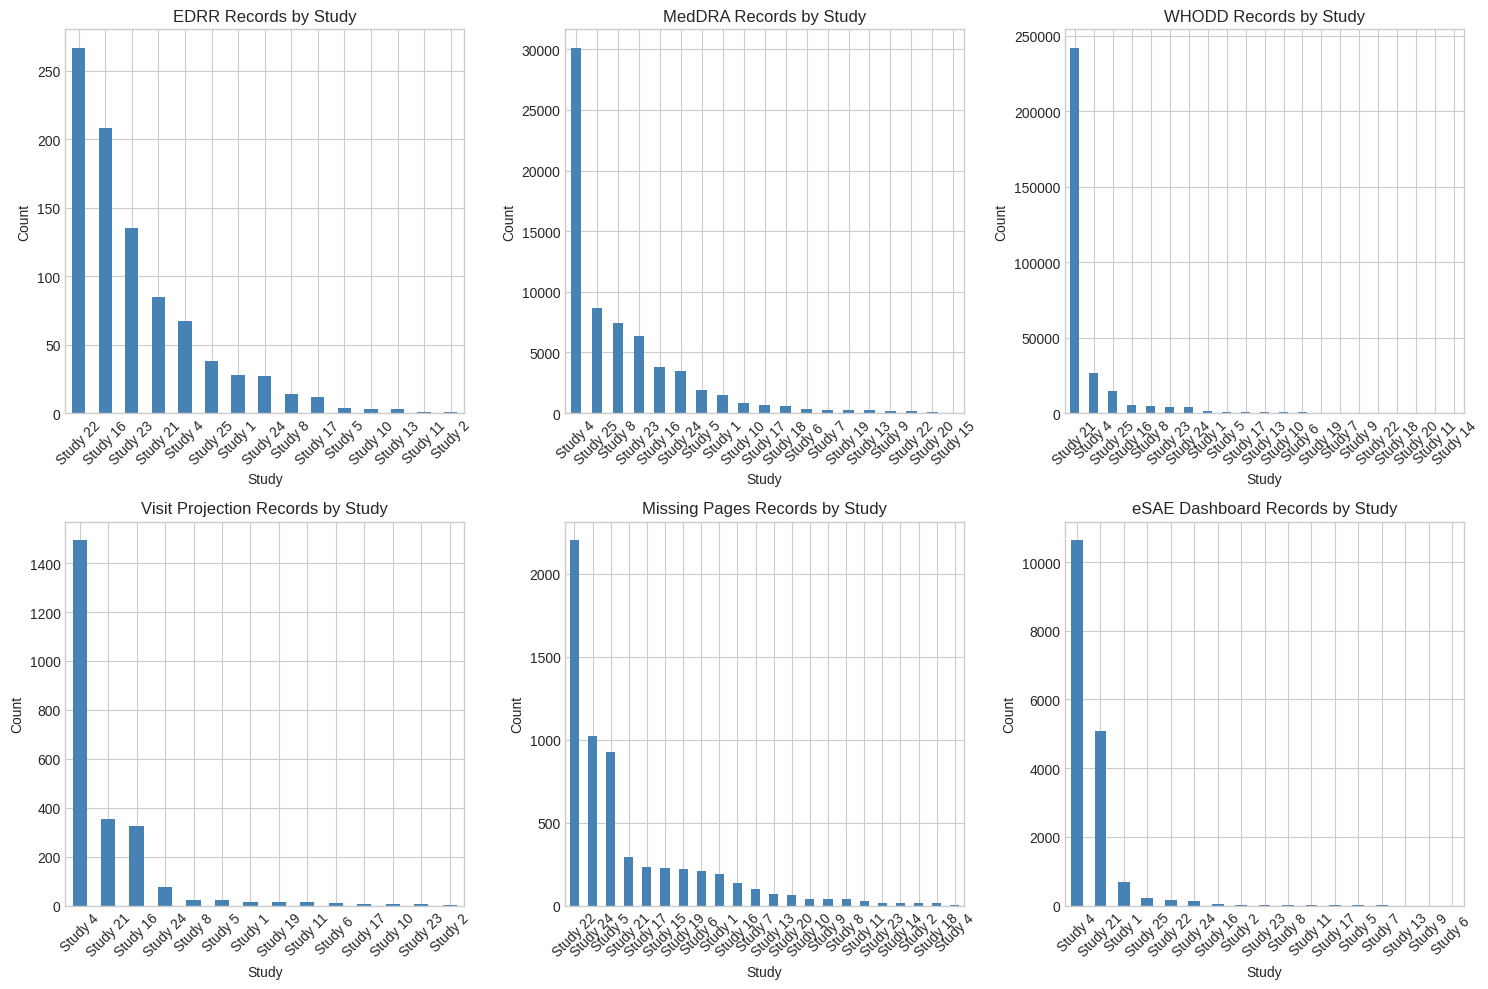

In [12]:
# Study distribution
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for ax, (name, df) in zip(axes.flatten(), datasets.items()):
    if not df.empty and '_source_study' in df.columns:
        counts = df['_source_study'].value_counts()
        counts.plot(kind='bar', ax=ax, color='steelblue')
        ax.set_title(f'{name} Records by Study')
        ax.set_xlabel('Study')
        ax.set_ylabel('Count')
        ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('study_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
# MedDRA Coding Status Analysis
if not df_meddra.empty:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Coding Status distribution
    if 'Coding Status' in df_meddra.columns:
        df_meddra['Coding Status'].value_counts().plot(
            kind='pie', ax=axes[0], autopct='%1.1f%%', colors=plt.cm.Set3.colors
        )
        axes[0].set_title('MedDRA Coding Status Distribution')
    
    # Require Coding distribution
    if 'Require Coding' in df_meddra.columns:
        df_meddra['Require Coding'].value_counts().plot(
            kind='bar', ax=axes[1], color=['green', 'red']
        )
        axes[1].set_title('Require Coding Distribution')
        axes[1].set_xlabel('Require Coding')
        axes[1].set_ylabel('Count')
    
    plt.tight_layout()
    plt.savefig('meddra_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()

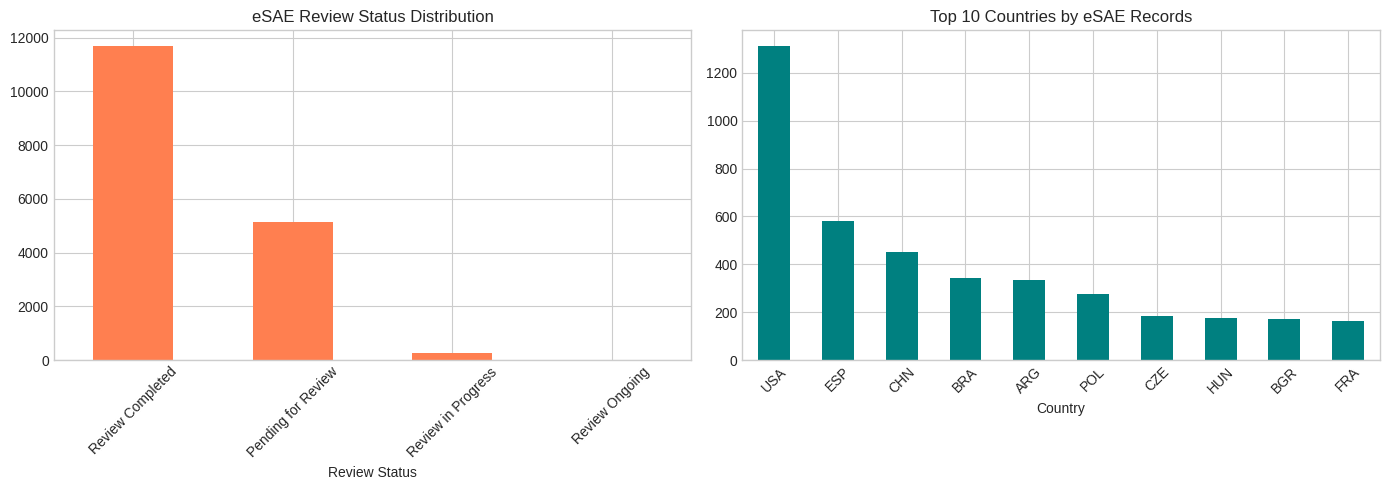

In [13]:
# eSAE Dashboard Analysis
if not df_esae.empty:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Review Status
    if 'Review Status' in df_esae.columns:
        df_esae['Review Status'].value_counts().plot(
            kind='bar', ax=axes[0], color='coral'
        )
        axes[0].set_title('eSAE Review Status Distribution')
        axes[0].tick_params(axis='x', rotation=45)
    
    # Country distribution
    if 'Country' in df_esae.columns:
        df_esae['Country'].value_counts().head(10).plot(
            kind='bar', ax=axes[1], color='teal'
        )
        axes[1].set_title('Top 10 Countries by eSAE Records')
        axes[1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.savefig('esae_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()

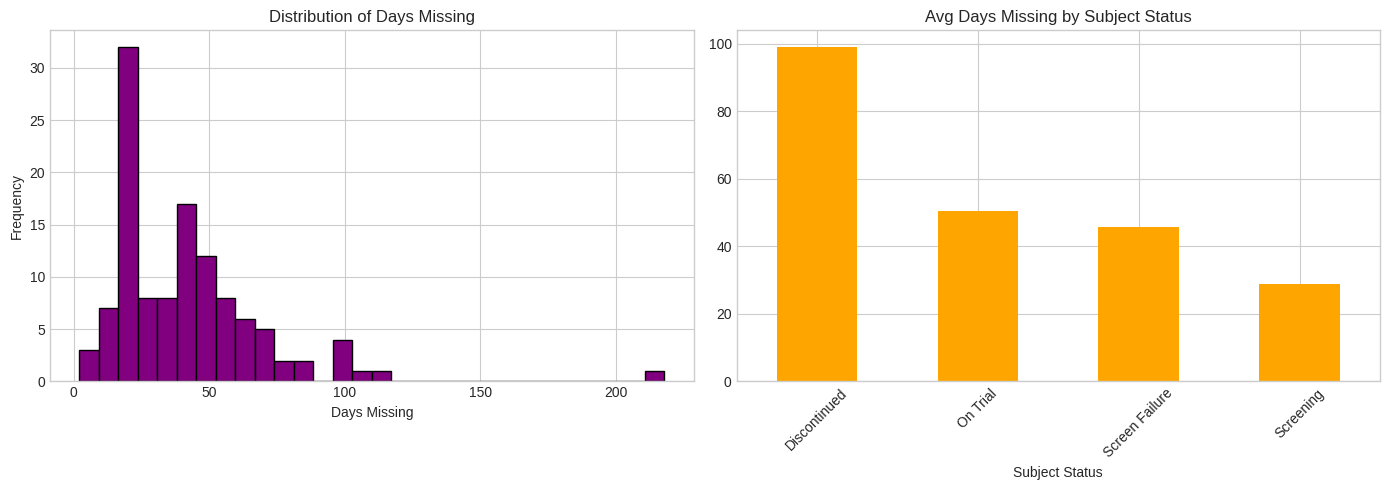

In [14]:
# Missing Pages Analysis
if not df_missing_pages.empty and '# of Days Missing' in df_missing_pages.columns:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Days missing distribution
    df_missing_pages['# of Days Missing'].dropna().hist(
        bins=30, ax=axes[0], color='purple', edgecolor='black'
    )
    axes[0].set_title('Distribution of Days Missing')
    axes[0].set_xlabel('Days Missing')
    axes[0].set_ylabel('Frequency')
    
    # By Subject Status
    if 'Subject Status' in df_missing_pages.columns:
        df_missing_pages.groupby('Subject Status')['# of Days Missing'].mean().plot(
            kind='bar', ax=axes[1], color='orange'
        )
        axes[1].set_title('Avg Days Missing by Subject Status')
        axes[1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.savefig('missing_pages_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()

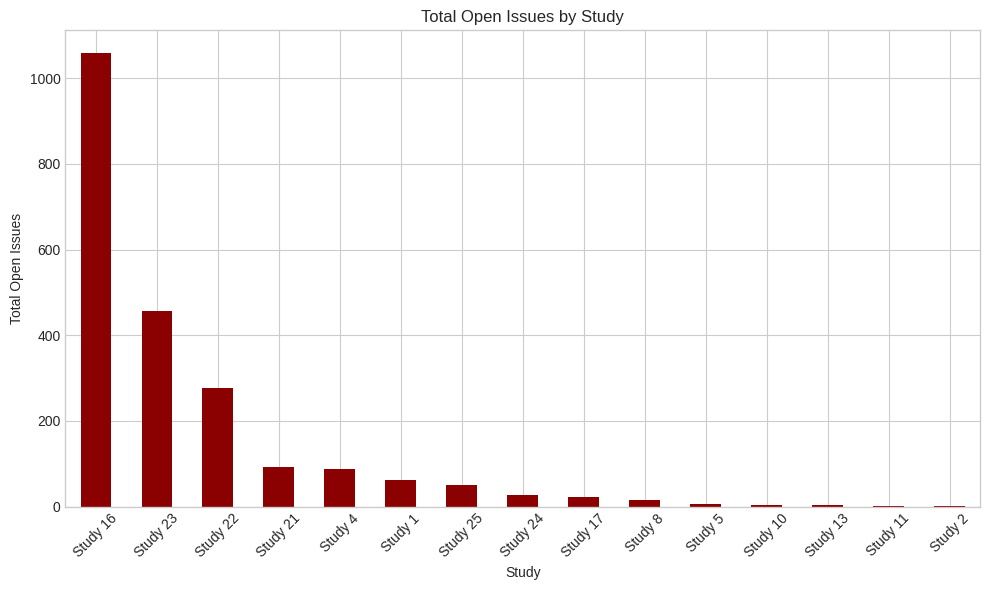

In [15]:
# EDRR Open Issues Analysis
if not df_edrr.empty:
    issue_col = [c for c in df_edrr.columns if 'issue' in c.lower() or 'count' in c.lower()]
    if issue_col:
        fig, ax = plt.subplots(figsize=(10, 6))
        issues_by_study = df_edrr.groupby('_source_study')[issue_col[0]].sum().sort_values(ascending=False)
        issues_by_study.plot(kind='bar', ax=ax, color='darkred')
        ax.set_title('Total Open Issues by Study')
        ax.set_xlabel('Study')
        ax.set_ylabel('Total Open Issues')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig('edrr_analysis.png', dpi=150, bbox_inches='tight')
        plt.show()

## 5. Data Preprocessing

In [18]:
# Preprocessing functions
def clean_column_names(df):
    """Standardize column names"""
    df.columns = df.columns.str.strip().str.replace(r'\s+', '_', regex=True)
    df.columns = df.columns.str.replace(r'[^\w]', '_', regex=True)
    df.columns = df.columns.str.lower()
    return df

def remove_empty_columns(df, threshold=0.95):
    """Remove columns with >threshold missing values"""
    missing_pct = df.isnull().sum() / len(df)
    cols_to_keep = missing_pct[missing_pct < threshold].index
    return df[cols_to_keep]

def remove_duplicate_rows(df):
    """Remove duplicate rows"""
    return df.drop_duplicates()

def remove_duplicate_columns(df):
    """Remove duplicate column names, keeping the first occurrence"""
    # Get unique columns, keeping first occurrence
    df = df.loc[:, ~df.columns.duplicated(keep='first')]
    return df


def standardize_dates(df, date_cols=None):
    """Convert date columns to datetime"""
    if date_cols is None:
        date_cols = [c for c in df.columns if 'date' in c.lower() or 'timestamp' in c.lower()]
    for col in date_cols:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], errors='coerce')
    return df

def preprocess_dataframe(df, name):
    """Apply all preprocessing steps"""
    print(f'\nPreprocessing {name}...')
    original_shape = df.shape
    
    df = clean_column_names(df)
    df = remove_duplicate_columns(df) 
    df = remove_empty_columns(df)
    df = remove_duplicate_rows(df)
    df = standardize_dates(df)
    
    print(f'  Shape: {original_shape} -> {df.shape}')
    return df

In [19]:
# Apply preprocessing
processed_datasets = {}
for name, df in datasets.items():
    if not df.empty:
        processed_datasets[name] = preprocess_dataframe(df.copy(), name)


Preprocessing EDRR...
  Shape: (893, 5) -> (893, 4)

Preprocessing MedDRA...
  Shape: (66858, 11) -> (66858, 11)

Preprocessing WHODD...
  Shape: (308050, 11) -> (306702, 11)

Preprocessing Visit Projection...
  Shape: (2375, 19) -> (871, 9)

Preprocessing Missing Pages...
  Shape: (6116, 25) -> (5524, 13)

Preprocessing eSAE Dashboard...
  Shape: (17098, 13) -> (17098, 11)


In [20]:
# Verify preprocessing
for name, df in processed_datasets.items():
    print(f'\n{name}:')
    print(f'  Columns: {list(df.columns)[:10]}...')
    print(f'  Shape: {df.shape}')


EDRR:
  Columns: ['study', 'subject', 'total_open_issue_count_per_subject', '_source_study']...
  Shape: (893, 4)

MedDRA:
  Columns: ['meddra_coding_report', 'study', 'dictionary', 'dictionary_version_number', 'subject', 'form_oid', 'logline', 'field_oid', 'coding_status', 'require_coding']...
  Shape: (66858, 11)

WHODD:
  Columns: ['whodrug_coding_report', 'study', 'dictionary', 'dictionary_version_number', 'subject', 'form_oid', 'logline', 'field_oid', 'coding_status', 'require_coding']...
  Shape: (306702, 11)

Visit Projection:
  Columns: ['country', 'site', 'subject', 'visit', 'projected_date', '__days_outstanding', '_source_study', 'actual_date', '__days_outstanding__today___projected_date_']...
  Shape: (871, 9)

Missing Pages:
  Columns: ['study_name', 'sitegroupname_countryname_', 'sitenumber', 'subjectname', 'overall_subject_status', 'visit_level_subject_status', 'foldername', 'visit_date', 'form_type__summary_or_visit_', 'formname']...
  Shape: (5524, 13)

eSAE Dashboard:

## 6. Feature Engineering

In [21]:
# Create aggregated metrics per study
study_metrics = pd.DataFrame()

# EDRR metrics
if 'EDRR' in processed_datasets:
    edrr = processed_datasets['EDRR']
    issue_col = [c for c in edrr.columns if 'issue' in c or 'count' in c]
    if issue_col:
        edrr_agg = edrr.groupby('_source_study').agg({
            issue_col[0]: ['sum', 'mean', 'max']
        }).reset_index()
        edrr_agg.columns = ['study', 'total_issues', 'avg_issues', 'max_issues']
        study_metrics = edrr_agg

# MedDRA metrics
if 'MedDRA' in processed_datasets:
    meddra = processed_datasets['MedDRA']
    meddra_agg = meddra.groupby('_source_study').size().reset_index(name='meddra_records')
    meddra_agg.columns = ['study', 'meddra_records']
    if not study_metrics.empty:
        study_metrics = study_metrics.merge(meddra_agg, on='study', how='outer')
    else:
        study_metrics = meddra_agg

# eSAE metrics
if 'eSAE Dashboard' in processed_datasets:
    esae = processed_datasets['eSAE Dashboard']
    esae_agg = esae.groupby('_source_study').size().reset_index(name='esae_records')
    esae_agg.columns = ['study', 'esae_records']
    if not study_metrics.empty:
        study_metrics = study_metrics.merge(esae_agg, on='study', how='outer')
    else:
        study_metrics = esae_agg

print('Study-level metrics:')
study_metrics.fillna(0, inplace=True)
study_metrics

Study-level metrics:


,study,total_issues,avg_issues,max_issues,meddra_records,esae_records
0,Study 1,61,2.178571,6,1513.0,700.0
1,Study 10,3,1.000000,1,796.0,0.0
2,Study 11,1,1.000000,1,0.0,14.0
3,Study 13,3,1.000000,1,259.0,3.0
4,Study 15,0,0.000000,0,3.0,0.0
5,Study 16,1059,5.091346,17,3771.0,44.0
6,Study 17,22,1.833333,3,654.0,8.0
7,Study 18,0,0.000000,0,596.0,0.0
8,Study 19,0,0.000000,0,259.0,0.0
9,Study 2,1,1.000000,1,0.0,25.0


## 7. Save Processed Data

In [22]:
# Create output directory
output_dir = Path('processed_data')
output_dir.mkdir(exist_ok=True)

# Save processed datasets
for name, df in processed_datasets.items():
    filename = output_dir / f'{name.lower().replace(" ", "_")}_processed.csv'
    df.to_csv(filename, index=False)
    print(f'Saved: {filename}')

# Save study metrics
study_metrics.to_csv(output_dir / 'study_metrics.csv', index=False)
print(f'Saved: {output_dir / "study_metrics.csv"}')

Saved: processed_data/edrr_processed.csv
Saved: processed_data/meddra_processed.csv
Saved: processed_data/whodd_processed.csv
Saved: processed_data/visit_projection_processed.csv
Saved: processed_data/missing_pages_processed.csv
Saved: processed_data/esae_dashboard_processed.csv
Saved: processed_data/study_metrics.csv


## 8. Summary Statistics

In [23]:
# Final summary
print('\n' + '='*60)
print('EDA & PREPROCESSING SUMMARY')
print('='*60)
print(f'\nTotal Studies Analyzed: {len(study_dirs)}')
print(f'\nDatasets Processed:')
for name, df in processed_datasets.items():
    print(f'  - {name}: {df.shape[0]} rows, {df.shape[1]} columns')
print(f'\nOutput files saved to: {output_dir.absolute()}')


EDA & PREPROCESSING SUMMARY

Total Studies Analyzed: 23

Datasets Processed:
  - EDRR: 893 rows, 4 columns
  - MedDRA: 66858 rows, 11 columns
  - WHODD: 306702 rows, 11 columns
  - Visit Projection: 871 rows, 9 columns
  - Missing Pages: 5524 rows, 13 columns
  - eSAE Dashboard: 17098 rows, 11 columns

Output files saved to: /home/srinjoy-das/Desktop/Novartis/processed_data
